In [31]:
import os, sys, simplejson
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# tf and keras
import keras, tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences

# spacy
import spacy
import en_core_web_sm

### Load data and pre-process data

In [2]:
recipe_df = pd.read_csv("../data/clean_recipes.csv", header=0, delimiter=";")

# drop null rows with null Ingredients and Directions
recipe_df.dropna(subset = ["Ingredients", "Directions"], inplace=True)
recipe_df.reset_index(inplace=True)

# lower case Ingredients and Directions
recipe_df["Ingredients"] = recipe_df["Ingredients"].apply(lambda x: x.lower())
recipe_df["Directions"] = recipe_df["Directions"].apply(lambda x: x.lower())

# # replace <space> with _ for Ingredients column
# recipe_df["Ingredients"] = recipe_df["Ingredients"].apply(lambda x: x.replace(" ", "_"))

recipe_df

,index,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","dissolve yeast in warm water.**stir in sugar, ...",7000
1,1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'preheat oven to 350 degrees f (175 degrees c)...,7001
2,2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",preheat oven to 350 degrees f (175 degrees c)....,7003
3,3,Apple Raisin Bread Recipe,39,https://images.media-allrecipes.com/userphotos...,Helen Hanson,15 m,1 h,1 h 15 m,"flour,baking powder,baking soda,salt,cinnamon,...",preheat oven to 350 degrees f (175 degrees c)....,7006
4,4,Buttermilk Oatmeal Bread Recipe,41,https://images.media-allrecipes.com/userphotos...,Helen Hanson,10 m,1 h,1 h 40 m,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",mix oats with buttermilk. let stand for 1/2 h...,7007
...,...,...,...,...,...,...,...,...,...,...,...
12340,12346,Hot Coffee Frosting Recipe,5,https://images.media-allrecipes.com/userphotos...,Jean,30 m,30 m,1 h,"sugar,butter,cocoa powder,vanilla,coffee","'in a large bowl, combine confectioners'' suga...",27456
12341,12347,White Chocolate Blueberry Cheesecake Recipe,78,https://images.media-allrecipes.com/userphotos...,Scott M.,20 m,1 h,1 h 20 m,"crust:,ham,almond,white sugar,butter,caramel,f...",preheat oven to 275 degrees f (135 degrees c)....,27478
12342,12348,'Aunt Anne''s Coffee Cake Recipe ',704,https://images.media-allrecipes.com/userphotos...,Mary,20 m,25 m,45 m,"flour,white sugar,baking powder,salt,butter,eg...",preheat oven to 350 degrees f (175 degrees c)....,27491
12343,12349,Giant Ding Dong Cake Recipe,157,https://images.media-allrecipes.com/userphotos...,TheThreeDogKitchen,25 m,50 m,2 h 15 m,"cake,chocolate,egg,water,vegetable oil,flour,m...",preheat oven to 350 degrees f (175 degrees c)....,27511


### Process columns and plot

In [3]:
# process Review Count column

def normalize_review_count(x):
    if x.endswith("k") or x.endswith("K"):
        return int(x[:-1])*1000
    else:
        return int(x)
    
recipe_df["Review Count"] = recipe_df["Review Count"].apply(normalize_review_count)

<AxesSubplot:ylabel='Recipe Name'>

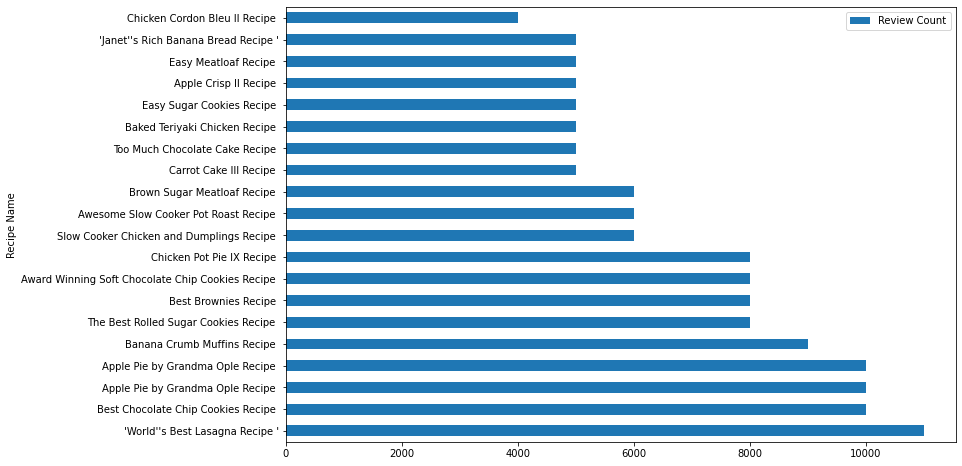

In [4]:
# Top 20 Recipes with highes review count

recipe_df.nlargest(20, "Review Count") \
.plot(x="Recipe Name", y="Review Count", kind="barh", figsize=(12, 8), rot=0)

<AxesSubplot:xlabel='Author'>

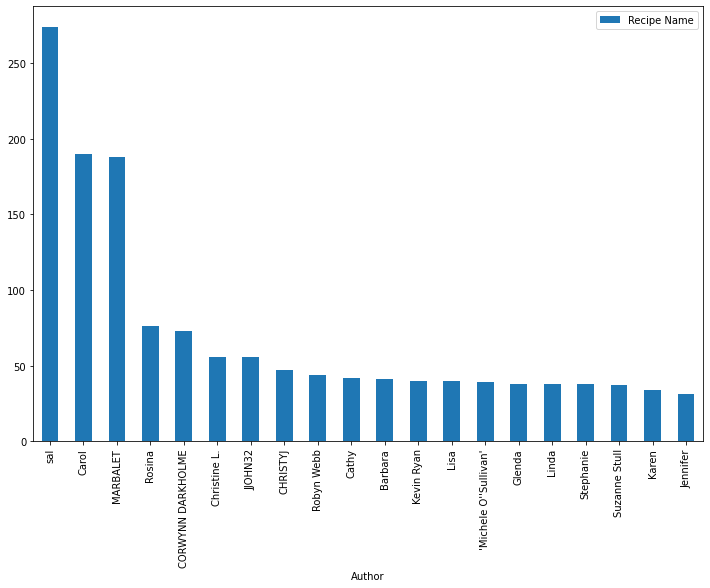

In [5]:
# Top 20 Authors

recipe_df.groupby("Author").count() \
    .reset_index()[["Author", "Recipe Name"]] \
    .set_index("Author").nlargest(20, "Recipe Name") \
    .plot(kind="bar", figsize=(12, 8), rot=90)

In [6]:
# process Prepare Time, Cook Time, and Total Time

def normalize_time_to_minutes(x):
    data = x.split(" ")
    if len(data) == 2:
        if data[1] == "m":
            return int(data[0])
        elif data[1] == "h":
            return int(data[0])*60
    elif len(data) == 4:
        return (int(data[0])*60) + (int(data[2]))

recipe_df["Cook Time"] = recipe_df["Cook Time"].apply(normalize_time_to_minutes)
recipe_df["Prepare Time"] = recipe_df["Prepare Time"].apply(normalize_time_to_minutes)
recipe_df["Total Time"] = recipe_df["Total Time"].apply(normalize_time_to_minutes)

recipe_df

,index,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25.0,15.0,190.0,"yeast,water,white sugar,salt,egg,butter,flour,...","dissolve yeast in warm water.**stir in sugar, ...",7000
1,1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15.0,60.0,80.0,"flour,salt,baking powder,poppy,butter,vegetabl...",'preheat oven to 350 degrees f (175 degrees c)...,7001
2,2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10.0,80.0,90.0,"flour,egg,white sugar,vegetable oil,applesauce...",preheat oven to 350 degrees f (175 degrees c)....,7003
3,3,Apple Raisin Bread Recipe,39,https://images.media-allrecipes.com/userphotos...,Helen Hanson,15.0,60.0,75.0,"flour,baking powder,baking soda,salt,cinnamon,...",preheat oven to 350 degrees f (175 degrees c)....,7006
4,4,Buttermilk Oatmeal Bread Recipe,41,https://images.media-allrecipes.com/userphotos...,Helen Hanson,10.0,60.0,100.0,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",mix oats with buttermilk. let stand for 1/2 h...,7007
...,...,...,...,...,...,...,...,...,...,...,...
12340,12346,Hot Coffee Frosting Recipe,5,https://images.media-allrecipes.com/userphotos...,Jean,30.0,30.0,60.0,"sugar,butter,cocoa powder,vanilla,coffee","'in a large bowl, combine confectioners'' suga...",27456
12341,12347,White Chocolate Blueberry Cheesecake Recipe,78,https://images.media-allrecipes.com/userphotos...,Scott M.,20.0,60.0,80.0,"crust:,ham,almond,white sugar,butter,caramel,f...",preheat oven to 275 degrees f (135 degrees c)....,27478
12342,12348,'Aunt Anne''s Coffee Cake Recipe ',704,https://images.media-allrecipes.com/userphotos...,Mary,20.0,25.0,45.0,"flour,white sugar,baking powder,salt,butter,eg...",preheat oven to 350 degrees f (175 degrees c)....,27491
12343,12349,Giant Ding Dong Cake Recipe,157,https://images.media-allrecipes.com/userphotos...,TheThreeDogKitchen,25.0,50.0,135.0,"cake,chocolate,egg,water,vegetable oil,flour,m...",preheat oven to 350 degrees f (175 degrees c)....,27511


<AxesSubplot:ylabel='recipe'>

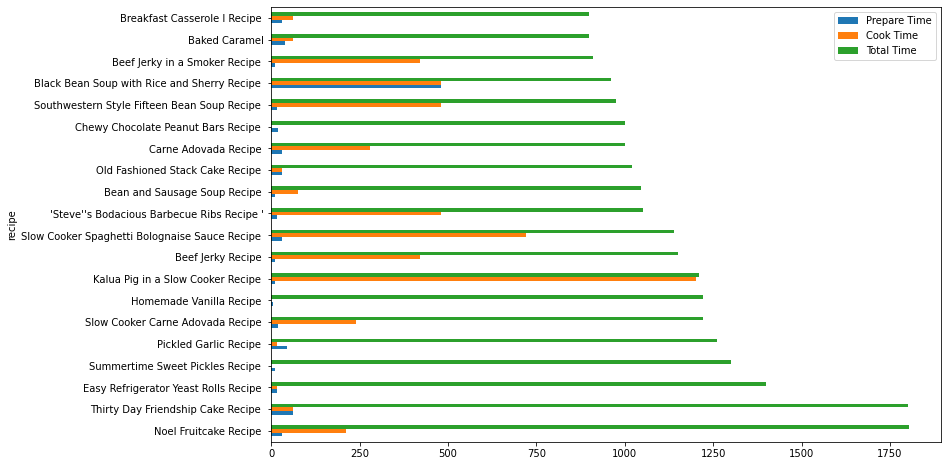

In [7]:
# Top 20 Recipes with longest Cooking Time

recipe_df.nlargest(20, "Total Time").plot(x="Recipe Name", 
                                          y=["Prepare Time", "Cook Time", "Total Time"],
                                          figsize=(12,8), kind="barh", rot=0,
                                          ylabel="time", xlabel="recipe")

### Tokenize Directions

In [8]:
nlp = en_core_web_sm.load(disable=['parser', 'tagger', 'ner'])
tokens = [nlp(direction) for direction in recipe_df["Directions"].values]

### Create vocabulary

In [9]:
def get_vocab_from_tokens(tokens):
    vocab = {"<UNK>": 1, "<PAD>": 0}
    for txt in tokens:
        for token in txt:
            if token.text not in vocab.keys():
                vocab[token.text] = len(vocab)
    return vocab

vocab = get_vocab_from_tokens(tokens)
print("Unique tokens : {}".format(len(vocab)))

Unique tokens : 14034


### Create Labels from Ingredients

In [10]:
## filter, clean and get labels

def _filter(token):
    if len(token) < 2 or token.is_stop or token.is_digit or token.like_num: # or token.text[0].islower()
        return False
    return True

def _clean(text):
    return text

def get_labels(ingredients, tokenized_instructions):
    labels = []
    for ing, ti in zip(ingredients, tokenized_instructions):
        ing = ing.split(",")
        #ing = [i.replace(" ", "_") for i in ing]
        l_i = []
        ci = [_clean(t.text) for i in ing for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
        label = []
        for token in ti:
            l_i.append(any((c == token.text or c == token.text[:-1] or c[:-1] == token.text) for c in ci))
        labels.append(l_i)
    return labels


# # test _filter and _clean for 1 item
# ingredients = recipe_df["Ingredients"][456].split(",")
# ingredients = [i.replace(" ", "_") for i in ingredients]
# clean = [_clean(t.text) for i in ingredients for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
# clean

labels = get_labels(recipe_df["Ingredients"], tokens)

In [16]:
# check a single entry

set([t.text for t, l in zip(tokens[0], labels[0]) if l])

{'butter', 'eggs', 'flour', 'salt', 'sugar', 'yeast'}

### Get max length of recipes

This is to find the length to pad, for the network inputs later. Based from the output, we will set MAX_LEN=300.
And also, my machine is just an old macbook pro 2013. It's laggy and deteriorating already in terms of performance.

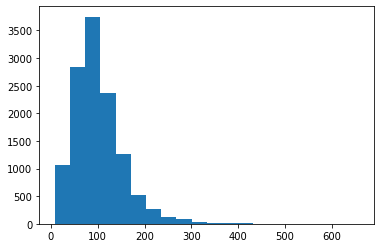

In [27]:
# plot in histogram 
plt.hist([len([t for t in token]) for token in tokens], bins=20);

In [29]:
MAX_LEN = 300

### Pad the sequence for a fixed length input

In [34]:
def process_sequences(tokens, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in tokens]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])

# prepare training data

X_seq = process_sequences(tokens, max_len=MAX_LEN, vocab=vocab)
print(X_seq.shape)

# prepare training labels

y_seq = []
for l in labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except:
            y_i.append(0.0)
    y_seq.append(np.array(y_i))
y_seq = np.array(y_seq)
y_seq = y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)
print(y_seq.shape)

(12345, 300)
(12345, 300, 1)


### Build LSTM Network Architecture

In [37]:
def build_model(vocab):
    model = None
    try:
        model = tf.keras.Sequential()
        model.add(layers.Embedding(input_dim=len(vocab), mask_zero=True, output_dim=50))
        model.add(layers.SpatialDropout1D(0.2))
        model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
        model.add(layers.SpatialDropout1D(0.2))
        model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
        model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
        model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    except Exception as ex:
        print("Problem in building network architecture : {}".format(ex))
        
    return model

model = build_model(vocab)
if model:
    model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          701700    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 50)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         58880     
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 128)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           129       
Total params: 859,525
Trainable params: 859,525
Non-trainable params: 0
________________________________________________

### Train / Fit

In [38]:
history = model.fit(X_seq, y_seq, epochs=10, batch_size=256, validation_split=0.1)

Epoch 1/10
44/44 [==============================] - 178s 4s/step - loss: 0.1670 - accuracy: 0.8526 - val_loss: 0.1073 - val_accuracy: 0.8899
Epoch 2/10
44/44 [==============================] - 143s 3s/step - loss: 0.0955 - accuracy: 0.8974 - val_loss: 0.0773 - val_accuracy: 0.8951
Epoch 3/10
44/44 [==============================] - 150s 3s/step - loss: 0.0672 - accuracy: 0.9100 - val_loss: 0.0257 - val_accuracy: 0.9730
Epoch 4/10
44/44 [==============================] - 127s 3s/step - loss: 0.0226 - accuracy: 0.9759 - val_loss: 0.0204 - val_accuracy: 0.9780
Epoch 5/10
44/44 [==============================] - 143s 3s/step - loss: 0.0203 - accuracy: 0.9784 - val_loss: 0.0194 - val_accuracy: 0.9801
Epoch 6/10
44/44 [==============================] - 204s 5s/step - loss: 0.0185 - accuracy: 0.9810 - val_loss: 0.0187 - val_accuracy: 0.9814
Epoch 7/10
44/44 [==============================] - 163s 4s/step - loss: 0.0183 - accuracy: 0.9815 - val_loss: 0.0183 - val_accuracy: 0.9819
Epoch 8/10
44

### Save model

In [40]:
model.save("../models/fs_lstm_v1.0.h5", save_format="h5")

### Plot training history: Log loss

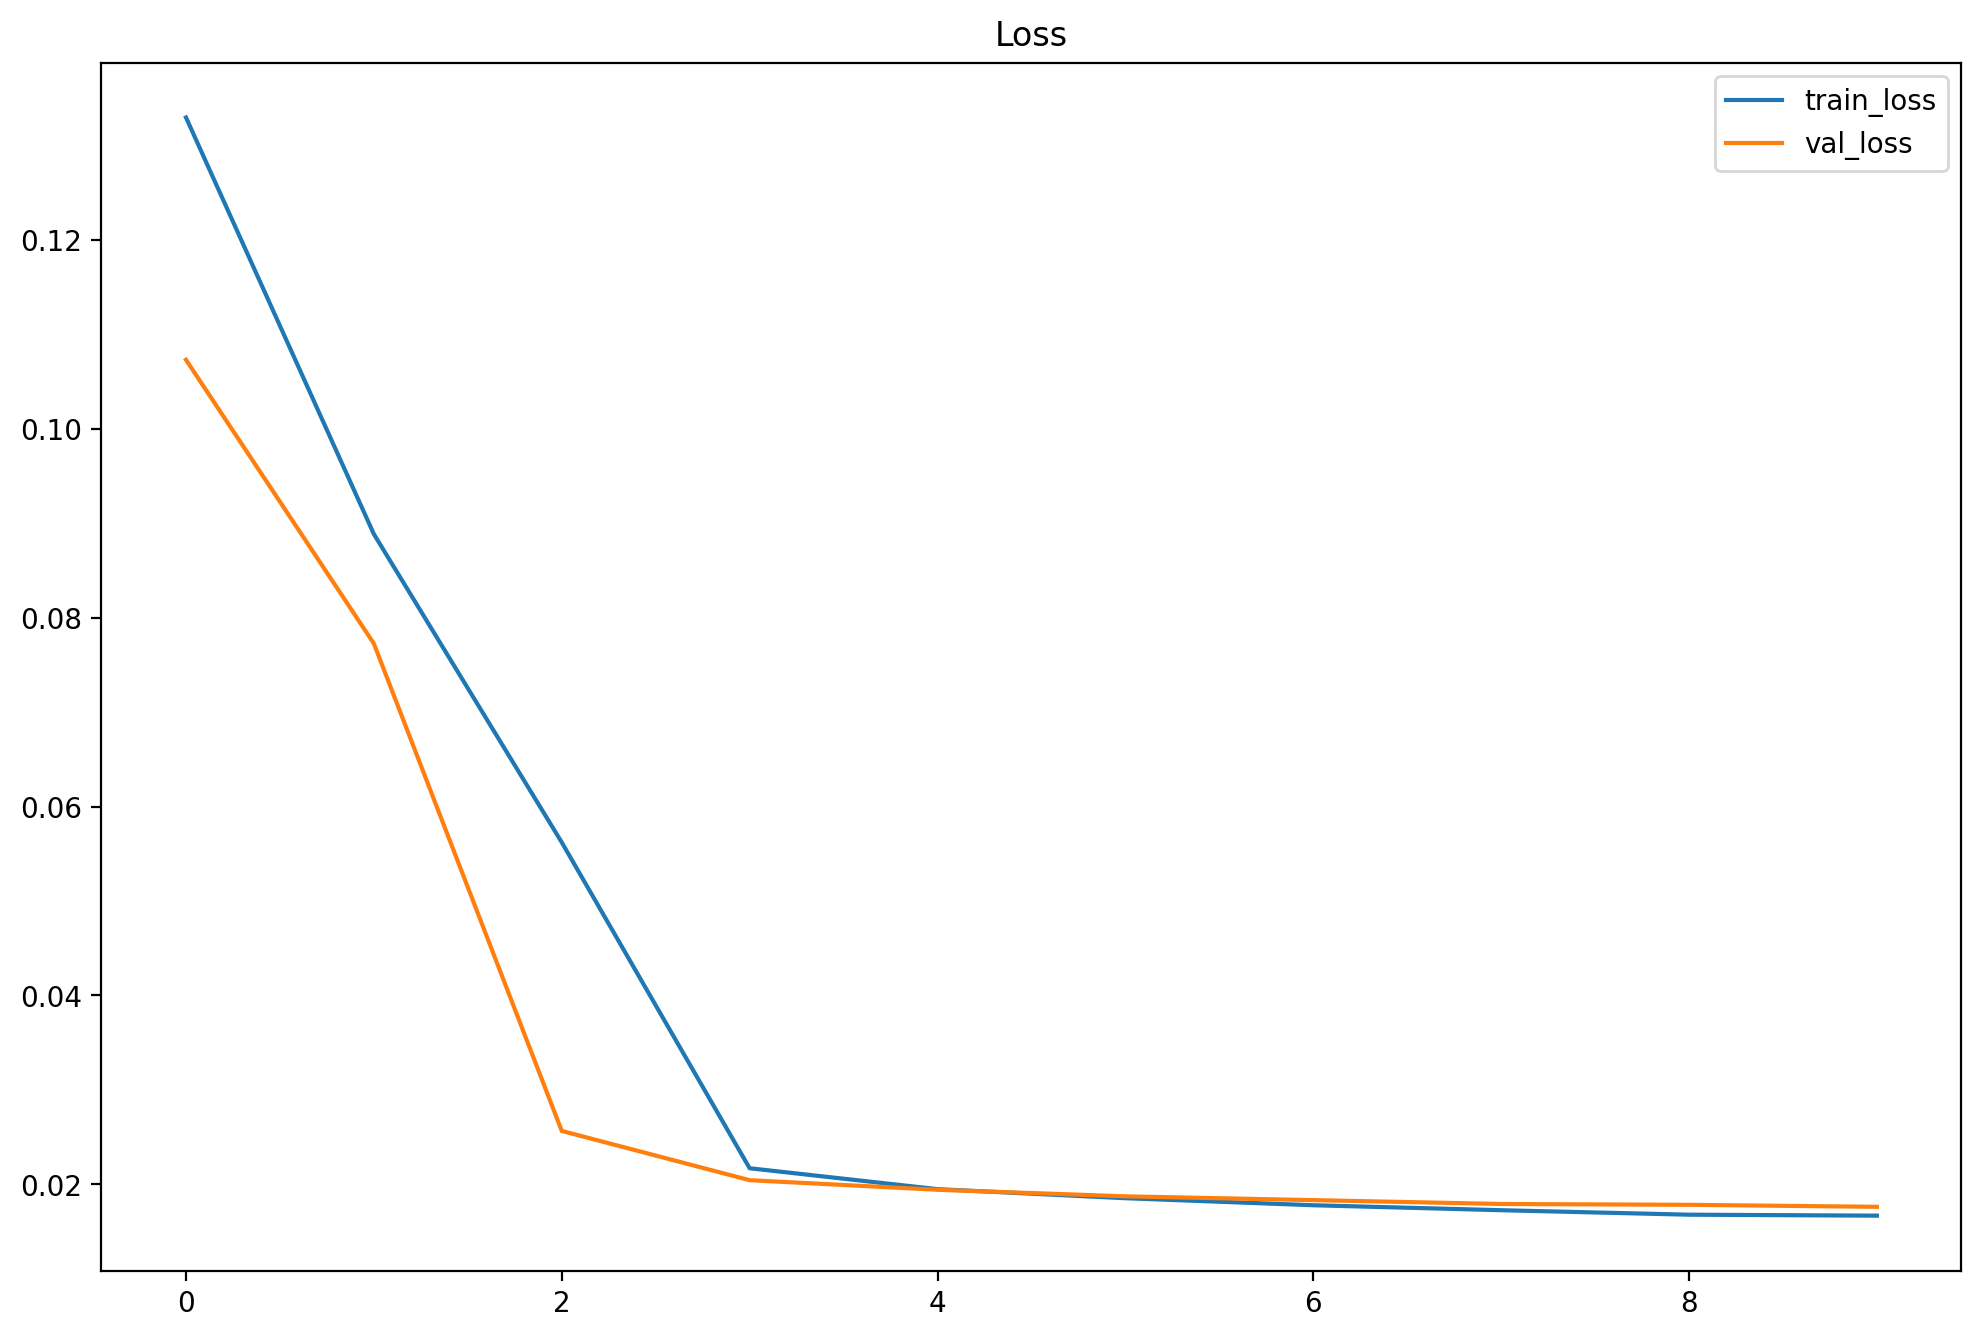

In [45]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(history.history["loss"], label="train_loss");
plt.plot(history.history["val_loss"], label="val_loss");
plt.legend();
plt.title("Loss");

### Plot training history: Accuracy

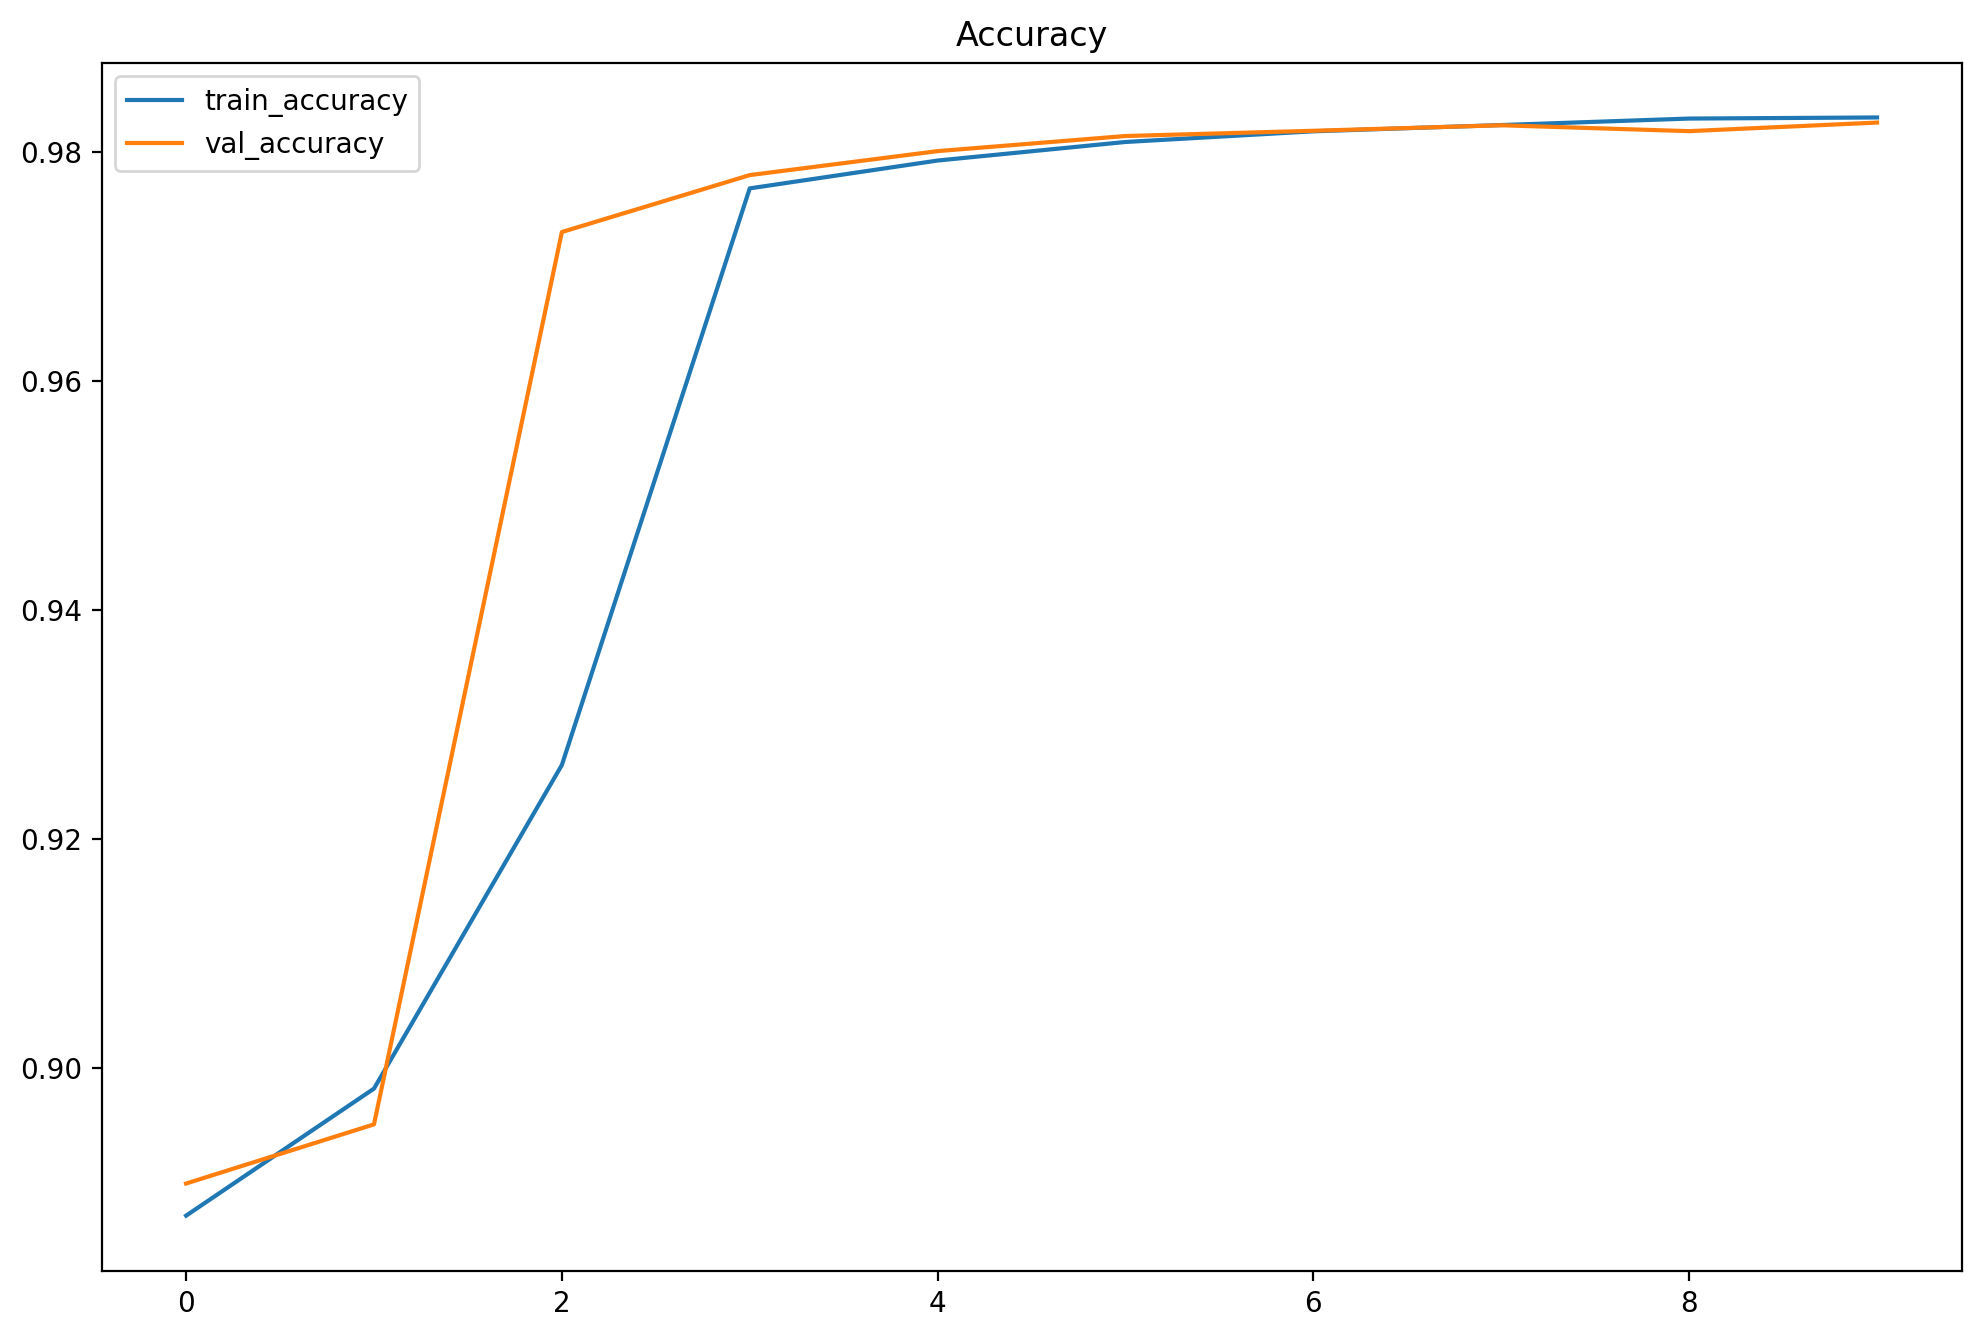

In [48]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(history.history["accuracy"], label="train_accuracy");
plt.plot(history.history["val_accuracy"], label="val_accuracy");
plt.legend();
plt.title("Accuracy");